In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 8s 798ms/step - loss: 1.4871e-05
Average validation loss: 0.566394567489624
4/4 [==============================] - 8s 813ms/step - loss: 1.4871e-05 - val_loss: 0.5664
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 11s 744ms/step - loss: 1.2465e-05 - val_loss: 0.5664
Average validation loss: 0.47268301248550415
4/4 [==============================] - 11s 770ms/step - loss: 1.2465e-05 - val_loss: 0.5195
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 14s 716ms/step - loss: 1.0588e-05 - val_loss: 0.5195
Average validation loss: 0.40434199571609497
4/4 [==============================] - 14s 728ms/step 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 702ms/step - loss: 7.8918e-07
Average validation loss: 0.00016203360428335145
8/8 [==============================] - 6s 711ms/step - loss: 7.8918e-07 - val_loss: 1.6203e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 695ms/step - loss: 7.9796e-07 - val_loss: 1.6203e-04
Average validation loss: 0.00023910602612886578
8/8 [==============================] - 11s 705ms/step - loss: 7.9796e-07 - val_loss: 2.0057e-04
Epoch 3/10
8/8 [==============================] - 17s 698ms/step - loss: 7.7767e-07 - val_loss: 2.0057e-04
Average validation loss: 0.0004791356041096151
8/8 [==============================] - 17s 707ms/step - loss: 7.7767e-07 - val_loss: 2.9343e-04
Epoch 4/10
8/8 [==============================] - 23s 716ms/step - loss: 7.6169e-07 - val_loss: 2.9343e-04


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 680ms/step - loss: 8.5427e-07
Average validation loss: 0.1429641779298739
12/12 [==============================] - 8s 694ms/step - loss: 8.5427e-07 - val_loss: 0.1430
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 707ms/step - loss: 8.4126e-07 - val_loss: 0.1430
Average validation loss: 0.12554184032342164
12/12 [==============================] - 17s 718ms/step - loss: 8.4126e-07 - val_loss: 0.1343
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 699ms/step - loss: 8.2164e-07 - val_loss: 0.1343
Average validation loss: 0.13932767727722725
12/12 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 688ms/step - loss: 7.7778e-07
Average validation loss: 0.2193312948620587
16/16 [==============================] - 11s 699ms/step - loss: 7.7778e-07 - val_loss: 0.2193
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 721ms/step - loss: 7.5558e-07 - val_loss: 0.2193
Average validation loss: 0.19678036065306515
16/16 [==============================] - 23s 731ms/step - loss: 7.5558e-07 - val_loss: 0.2081
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 34s 715ms/step - loss: 7.5708e-07 - val_loss: 0.2081
Average validation loss: 0.16882264459854923
16/16 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 737ms/step - loss: 7.5850e-07
Average validation loss: 0.2791124564479105
20/20 [==============================] - 15s 746ms/step - loss: 7.5850e-07 - val_loss: 0.2791
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 704ms/step - loss: 7.3728e-07 - val_loss: 0.2791
Average validation loss: 0.3444079314009286
20/20 [==============================] - 29s 713ms/step - loss: 7.3728e-07 - val_loss: 0.3118
Epoch 3/10
20/20 [==============================] - 43s 709ms/step - loss: 7.2850e-07 - val_loss: 0.3118
Average validation loss: 0.4318266295100329
20/20 [==============================] - 44s 719ms/step - loss: 7.2850e-07 - val_loss: 0.3518
Epoch 4/10
20/20 [==============================] - 58s 699ms/step - loss: 7.2762e-07 - val_loss: 0.3518
Average validation 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 706ms/step - loss: 5.9952e-07
Average validation loss: 0.41825254758199054
24/24 [==============================] - 17s 715ms/step - loss: 5.9952e-07 - val_loss: 0.4183
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 34s 701ms/step - loss: 5.7488e-07 - val_loss: 0.4183
Average validation loss: 0.2729417458176613
24/24 [==============================] - 34s 710ms/step - loss: 5.7488e-07 - val_loss: 0.3456
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 51s 699ms/step - loss: 5.3639e-07 - val_loss: 0.3456
Average validation loss: 0.2852241074045499
24/24 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 28s 697ms/step - loss: 7.2696e-07
Average validation loss: 0.4583296090364456
40/40 [==============================] - 28s 706ms/step - loss: 7.2696e-07 - val_loss: 0.4583
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 56s 693ms/step - loss: 6.7525e-07 - val_loss: 0.4583
Average validation loss: 0.4670132249593735
40/40 [==============================] - 56s 703ms/step - loss: 6.7525e-07 - val_loss: 0.4627
Epoch 3/10
40/40 [==============================] - 85s 702ms/step - loss: 6.4343e-07 - val_loss: 0.4627
Average validation loss: 0.47646149396896365
40/40 [==============================] - 85s 713ms/step - loss: 6.4343e-07 - val_loss: 0.4673
Epoch 4/10
40/40 [==============================] - 113s 702ms/step - loss: 6.2432e-07 - val_loss: 0.4673
Average validatio

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 708ms/step - loss: 5.3309e-07
Average validation loss: 0.45510530130074284
48/48 [==============================] - 34s 718ms/step - loss: 5.3309e-07 - val_loss: 0.4551
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 68s 707ms/step - loss: 5.1517e-07 - val_loss: 0.4551
Average validation loss: 0.3922976018632956
48/48 [==============================] - 69s 717ms/step - loss: 5.1517e-07 - val_loss: 0.4237
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 103s 706ms/step - loss: 4.7850e-07 - val_loss: 0.4237
Average validation loss: 0.4652658699875853
48/48 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 713ms/step - loss: 5.4379e-07
Average validation loss: 0.4977529608934544
56/56 [==============================] - 41s 723ms/step - loss: 5.4379e-07 - val_loss: 0.4978
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 79s 692ms/step - loss: 4.7623e-07 - val_loss: 0.4978
Average validation loss: 0.4754775992145629
56/56 [==============================] - 80s 702ms/step - loss: 4.7623e-07 - val_loss: 0.4866
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 120s 714ms/step - loss: 4.4801e-07 - val_loss: 0.4866
Average validation loss: 0.4798422572369288
56/56 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 45s 700ms/step - loss: 5.1926e-07
Average validation loss: 0.4977956225266098
64/64 [==============================] - 45s 710ms/step - loss: 5.1926e-07 - val_loss: 0.4978
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 91s 709ms/step - loss: 4.8239e-07 - val_loss: 0.4978
Average validation loss: 0.4653124929045589
64/64 [==============================] - 92s 720ms/step - loss: 4.8239e-07 - val_loss: 0.4816
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 136s 701ms/step - loss: 4.5917e-07 - val_loss: 0.4816
Average validation loss: 0.4908181846358275
64/64 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 707ms/step - loss: 5.0910e-07
Average validation loss: 0.5560108025868734
72/72 [==============================] - 52s 717ms/step - loss: 5.0910e-07 - val_loss: 0.5560
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 102s 702ms/step - loss: 4.8307e-07 - val_loss: 0.5560
Average validation loss: 0.45018915004200405
72/72 [==============================] - 103s 712ms/step - loss: 4.8307e-07 - val_loss: 0.5031
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 154s 703ms/step - loss: 4.3707e-07 - val_loss: 0.5031
Average validation loss: 0.519087091088295
72/72 [==============================]

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 57s 713ms/step - loss: 4.0867e-07
Average validation loss: 0.525609315931797
80/80 [==============================] - 58s 723ms/step - loss: 4.0867e-07 - val_loss: 0.5256
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 116s 726ms/step - loss: 3.7516e-07 - val_loss: 0.5256
Average validation loss: 0.4921766072511673
80/80 [==============================] - 117s 735ms/step - loss: 3.7516e-07 - val_loss: 0.5089
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 173s 705ms/step - loss: 3.4893e-07 - val_loss: 0.5089
Average validation loss: 0.5049329333007335
80/80 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 68s 703ms/step - loss: 5.6772e-07
Average validation loss: 0.7136468518147012
96/96 [==============================] - 68s 713ms/step - loss: 5.6772e-07 - val_loss: 0.7136
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 136s 701ms/step - loss: 5.2158e-07 - val_loss: 0.7136
Average validation loss: 0.6622309269829808
96/96 [==============================] - 137s 711ms/step - loss: 5.2158e-07 - val_loss: 0.6879
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 205s 706ms/step - loss: 4.7216e-07 - val_loss: 0.6879
Average validation loss: 0.6086975354022192
96/96 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 93s 771ms/step - loss: 4.1748e-07
Average validation loss: 0.5160849337369048
120/120 [==============================] - 94s 781ms/step - loss: 4.1748e-07 - val_loss: 0.5161
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 186s 768ms/step - loss: 3.8743e-07 - val_loss: 0.5161
Average validation loss: 0.5240659139836983
120/120 [==============================] - 187s 779ms/step - loss: 3.8743e-07 - val_loss: 0.5201
Epoch 3/10
120/120 [==============================] - 280s 772ms/step - loss: 3.6808e-07 - val_loss: 0.5201
Average validation loss: 0.5201519246125826
120/120 [==============================] - 281s 783ms/step - loss: 3.6808e-07 - val_loss: 0.5201
Epoch 4/10
120/120 [==============================] - 374s 767ms/step - loss: 3.5336e-07 - val_loss: 0.5201

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 101s 700ms/step - loss: 4.4819e-07
Average validation loss: 0.43532794233275734
144/144 [==============================] - 102s 710ms/step - loss: 4.4819e-07 - val_loss: 0.4353
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 203s 700ms/step - loss: 4.1272e-07 - val_loss: 0.4353
Average validation loss: 0.4867667878619007
144/144 [==============================] - 204s 710ms/step - loss: 4.1272e-07 - val_loss: 0.4610
Epoch 3/10
144/144 [==============================] - 305s 701ms/step - loss: 3.7927e-07 - val_loss: 0.4610
Average validation loss: 0.5145765960310705
144/144 [==============================] - 307s 711ms/step - loss: 3.7927e-07 - val_loss: 0.4789
Epoch 4/10
144/144 [==============================] - 407s 699ms/step - loss: 3.5944e-07 - val_loss: 0.4

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 112s 699ms/step - loss: 3.0664e-07
Average validation loss: 0.5575439690219355
160/160 [==============================] - 114s 709ms/step - loss: 3.0664e-07 - val_loss: 0.5575
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 227s 708ms/step - loss: 2.8726e-07 - val_loss: 0.5575
Average validation loss: 0.5076065281245974
160/160 [==============================] - 228s 718ms/step - loss: 2.8726e-07 - val_loss: 0.5326
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 342s 709ms/step - loss: 2.7479e-07 - val_loss: 0.5326
Average validation loss: 0.5499228946704534
160/160 [===============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 141s 703ms/step - loss: 4.9297e-07
Average validation loss: 0.5414107871457235
200/200 [==============================] - 143s 713ms/step - loss: 4.9297e-07 - val_loss: 0.5414
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 283s 700ms/step - loss: 4.4146e-07 - val_loss: 0.5414
Average validation loss: 0.46519722186145374
200/200 [==============================] - 285s 711ms/step - loss: 4.4146e-07 - val_loss: 0.5033
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 424s 694ms/step - loss: 4.0430e-07 - val_loss: 0.5033
Average validation loss: 0.44392399258096704
200/200 [=============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:48 - loss: 2.1668e-07

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 169s 703ms/step - loss: 3.5602e-07
Average validation loss: 0.45207576735701877
240/240 [==============================] - 171s 713ms/step - loss: 3.5602e-07 - val_loss: 0.4521
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 340s 704ms/step - loss: 3.0643e-07 - val_loss: 0.4521
Average validation loss: 0.4933831049139068
240/240 [==============================] - 343s 714ms/step - loss: 3.0643e-07 - val_loss: 0.4727
Epoch 3/10
240/240 [==============================] - 512s 707ms/step - loss: 2.9170e-07 - val_loss: 0.4727
Average validation loss: 0.5482347773911898
240/240 [==============================] - 515s 717ms/step - loss: 2.9170e-07 - val_loss: 0.4979
Epoch 4/10
240/240 [==============================] - 684s 707ms/step - loss: 2.7748e-07 - val_loss: 0.4

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.07397161497734488, 0.08308023249519465, 0.237070557089246, 0.29409142174365116, 0.3211724256447051, 0.33871240519974277, 0.4936954402942502, 0.505273447137018, 0.5487504320948626, 0.5447409824889564, 0.5537705394583301, 0.5487969544176012, 0.594129832141989, 0.5288929210421242, 0.5006802236016483, 0.480566714656663, 0.48844721447345224, 0.44389877547110274]
std_val_losses =  [0.14114833159497858, 0.07550157594792396, 0.16981598276013624, 0.12110667332912636, 0.07998616417206642, 0.11083089619902037, 0.08729876753921195, 0.0463348950588013, 0.08358749029343579, 0.0640229530000498, 0.05635227030361455, 0.0492998605871906, 0.08017761058835515, 0.061211285053727776, 0.038348835768591535, 0.05714633656471195, 0.04066155339556348, 0.04973166077708764]


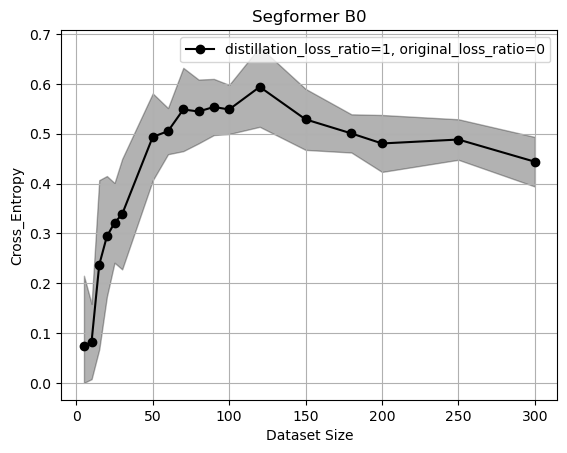

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()